(complementary:preconditioners)=
# Preconditioners in NGSolve

Preconditioners are approximate inverses which are used within iterative methods to solve linear or non-linear equations.

Here are some built-in preconditioners in NGSolve:

* Jacobi (`local`) and block Jacobi 
* Direct solvers using sparse factorization (`direct`)
* Geometric multigrid with different block-smoothers (`multigrid`)
* Algebraic multigrid preconditioner (`h1amg`)
* p-version element-level BDDC (`bddc`)

This tutorial quickly shows how to use some of these within a solver.

In [1]:
from ngsolve import *
import matplotlib.pyplot as plt

### A simple test problem 

In order to experiment with various preconditioners, 
let us define a simple Poisson solver with the name
of a preconditioner as the keyword argument `precond`.

In [2]:
def SolveProblem(h=0.5, p=1, levels=1, 
                 condense=False,
                 precond=preconditioners.Local, preflags={}):
    """
    Solve Poisson problem on l refinement levels.
    PARAMETERS:
        h: coarse mesh size
        p: polynomial degree 
        l: number of refinement levels
        condense: if true, perform static condensations
        precond: preconditioner class  (formerly: name of a built-in preconditioner)
    Returns: (ndof, niterations)
        List of tuples of number of degrees of freedom and iterations
    """
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    # mesh = Mesh(unit_cube.GenerateMesh(maxh=h))
    fes = H1(mesh, order=p, dirichlet="bottom|left")
    
    u, v = fes.TnT() 
    a = BilinearForm(grad(u)*grad(v)*dx, condense=condense)
    f = LinearForm(v*dx)
    gfu = GridFunction(fes)
    Draw(gfu)
    c = precond(a,**preflags)

    steps = []
    
    for l in range(levels):
        if l > 0: 
            mesh.Refine()
        fes.Update()
        gfu.Update()

        with TaskManager():
            a.Assemble()
            f.Assemble()

            # Conjugate gradient solver
            inv = CGSolver(a.mat, c.mat, maxsteps=1000)

            # Solve steps depend on condense 
            if condense:
                f.vec.data += a.harmonic_extension_trans * f.vec
            
            gfu.vec.data = inv * f.vec
            
            if condense:
                gfu.vec.data += a.harmonic_extension * gfu.vec
                gfu.vec.data += a.inner_solve * f.vec
        steps.append ( (fes.ndof, inv.GetSteps()) )
        if fes.ndof < 15000:
            Redraw()
    return steps

The `Preconditioner` registers itself to the `BilinearForm`. Whenever the `BilinearForm` is re-assembled, the `Preconditioner` is updated as well.

### The `local` preconditioner 

The `local` preconditioner is a simple Jacobi preconditioner. 
The number of CG-iterations with the local preconditioner is proportional to $h^{-1} \sim 2^l$:


In [3]:
SolveProblem(precond=preconditioners.Local)

[(8, 4)]

In [10]:
res_local = SolveProblem(levels=9, precond=preconditioners.Local, preflags={"GS":True})
res_local

[(8, 4),
 (21, 6),
 (65, 16),
 (225, 31),
 (833, 61),
 (3201, 119),
 (12545, 236),
 (49665, 452),
 (197633, 906)]

### Multigrid preconditioner 

A geometric multigrid `Preconditioner` uses the sequence of refined meshes to define a preconditioner yielding optimal iteration numbers (and complexity). It uses a direct solve on the coarsest level, and block Gauss-Seidel smoothers on the refined levels.

In [5]:
# res_mg = SolveProblem(levels=9, precond="multigrid")
res_mg = SolveProblem(levels=9, precond=preconditioners.MultiGrid)
res_mg

[(8, 2),
 (21, 4),
 (65, 7),
 (225, 8),
 (833, 8),
 (3201, 8),
 (12545, 8),
 (49665, 8),
 (197633, 8)]

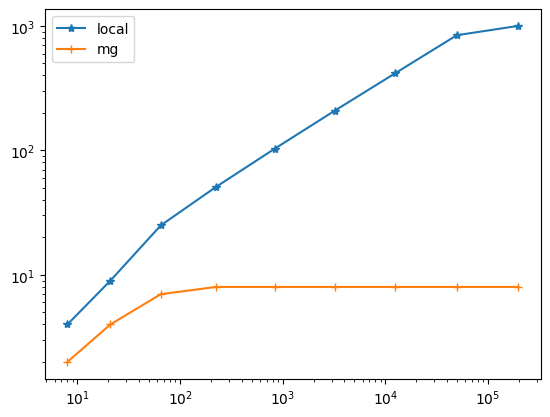

In [6]:
plt.xscale("log")
plt.yscale("log")
plt.plot(*zip(*res_local), "-*")
plt.plot(*zip(*res_mg), "-+")
plt.legend(['local', 'mg'])
plt.show()

###  Multigrid implementation for higher order spaces 

Another important preconditioner that is available in NGSolve is the multigrid preconditioner.

In [ ]:
for p in range(1,10):
    r = SolveProblem(h=0.5, p=p, levels=4, condense=False, 
                     precond=preconditioners.MultiGrid)
    print ("p=", p, ": ndof,nsteps=", r)          

p= 1 : ndof,nsteps= [(8, 2), (21, 4), (65, 7), (225, 8)]
p= 2 : ndof,nsteps= [(21, 5), (65, 6), (225, 8), (833, 8)]
p= 3 : ndof,nsteps= [(40, 9), (133, 12), (481, 12), (1825, 13)]
p= 4 : ndof,nsteps= [(65, 12), (225, 15), (833, 16), (3201, 16)]
p= 5 : ndof,nsteps= [(96, 14), (341, 19), (1281, 20), (4961, 20)]
p= 6 : ndof,nsteps= [(133, 16), (481, 23), (1825, 23), (7105, 23)]
p= 7 : ndof,nsteps= [(176, 18), (645, 25), (2465, 26), (9633, 26)]
p= 8 : ndof,nsteps= [(225, 19), (833, 27), (3201, 28), (12545, 28)]
p= 9 : ndof,nsteps= [(280, 20), (1045, 29), (4033, 30), (15841, 30)]


We observe that the number of iterations grows mildly with the degree $p$ while remaining  bounded with mesh refinement.

Performing static condensation improves the situation:

In [8]:
for p in range(1,10):
    r = SolveProblem(h=0.5, p=p, levels=4, condense=True, 
                     precond=preconditioners.MultiGrid)
    print ("p=", p, ": ndof,nsteps=", r)       

p= 1 : ndof,nsteps= [(8, 2), (21, 4), (65, 7), (225, 8)]
p= 2 : ndof,nsteps= [(21, 5), (65, 6), (225, 8), (833, 8)]
p= 3 : ndof,nsteps= [(40, 5), (133, 6), (481, 7), (1825, 8)]
p= 4 : ndof,nsteps= [(65, 5), (225, 6), (833, 7), (3201, 8)]
p= 5 : ndof,nsteps= [(96, 5), (341, 6), (1281, 7), (4961, 8)]
p= 6 : ndof,nsteps= [(133, 5), (481, 6), (1825, 7), (7105, 8)]
p= 7 : ndof,nsteps= [(176, 5), (645, 6), (2465, 7), (9633, 8)]
p= 8 : ndof,nsteps= [(225, 5), (833, 6), (3201, 7), (12545, 8)]
p= 9 : ndof,nsteps= [(280, 5), (1045, 6), (4033, 7), (15841, 8)]


### Element-wise BDDC preconditioner

A built-in element-wise BDDC (Balancing Domain Decomposition preconditioner with Constraints) preconditioner is also available. In contrast to local or multigrid preconditioners, the BDDC preconditioner needs access to the element matrices. This is exactly why we need to register the preconditioner with the bilinear form `bfa` before calling `bfa.Assemble()`.

In [9]:
for p in range(1,10):
    r = SolveProblem(h=0.5, p=p, levels=4, condense=True, 
                     precond=preconditioners.BDDC)
    print ("p=", p, ": ndof,nsteps=", r)  

p= 1 : ndof,nsteps= [(8, 2), (21, 2), (65, 2), (225, 2)]
p= 2 : ndof,nsteps= [(21, 7), (65, 12), (225, 16), (833, 17)]
p= 3 : ndof,nsteps= [(40, 11), (133, 16), (481, 20), (1825, 22)]
p= 4 : ndof,nsteps= [(65, 13), (225, 18), (833, 24), (3201, 26)]
p= 5 : ndof,nsteps= [(96, 14), (341, 19), (1281, 26), (4961, 29)]
p= 6 : ndof,nsteps= [(133, 14), (481, 20), (1825, 28), (7105, 31)]
p= 7 : ndof,nsteps= [(176, 15), (645, 21), (2465, 30), (9633, 33)]
p= 8 : ndof,nsteps= [(225, 16), (833, 23), (3201, 31), (12545, 35)]
p= 9 : ndof,nsteps= [(280, 16), (1045, 24), (4033, 33), (15841, 36)]


The BDDC preconditioner needs more iterations, but the work per iteration is less, so performance is similar to multigrid. **This element-wise BDDC preconditioner works well in shared memory parallel as well as in distributed memory mode.** See $\S$[2.1.4](../unit-2.1.4-bddc/bddc.ipynb) for more about BDDC preconditioner and how to combine it with an algebraic multigrid coarse solver. 